# Предобработка данных и Feature Engineering

В этой тетрадке рассмотрим:
1. Работу с пропущенными значениями
2. Обработку выбросов
3. Удаление шумов
4. Масштабирование признаков
5. Кодирование категориальных переменных
6. Создание новых признаков (Feature Engineering)
7. Отбор признаков (Feature Selection)

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris, make_classification, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif, RFE, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from scipy import stats

# Настройки отображения
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

In [2]:
!pip install missingno


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [10]:
# Создание датасета с пропусками
np.random.seed(42)
df = pd.DataFrame({
    'feature_1': np.random.randn(100),
    'feature_2': np.random.randn(100),
    'feature_3': np.random.randn(100),
    'category': np.random.choice(['A', 'B', 'C'], 100)
})

# Внесение пропусков
missing_indices_1 = np.random.choice(df.index, 15, replace=False)
missing_indices_2 = np.random.choice(df.index, 20, replace=False)
missing_indices_cat = np.random.choice(df.index, 10, replace=False)

df.loc[missing_indices_1, 'feature_1'] = np.nan
df.loc[missing_indices_2, 'feature_2'] = np.nan
df.loc[missing_indices_cat, 'category'] = np.nan

print("Исходные данные с пропусками:")
print(df.head(10))
print("\nИнформация о пропусках:")
print(df.isnull().sum())
print(f"\nПроцент пропусков: {df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100:.2f}%")

Исходные данные с пропусками:
   feature_1  feature_2  feature_3 category
0   0.496714  -1.415371   0.357787        A
1        NaN  -0.420645   0.560785        B
2   0.647689  -0.342715   1.083051        A
3        NaN  -0.802277   1.053802        A
4  -0.234153  -0.161286  -1.377669        C
5  -0.234137   0.404051  -0.937825        A
6        NaN        NaN   0.515035        C
7   0.767435        NaN   0.513786        B
8  -0.469474        NaN   0.515048        A
9   0.542560  -0.074446   3.852731        C

Информация о пропусках:
feature_1    15
feature_2    20
feature_3     0
category     10
dtype: int64

Процент пропусков: 11.25%


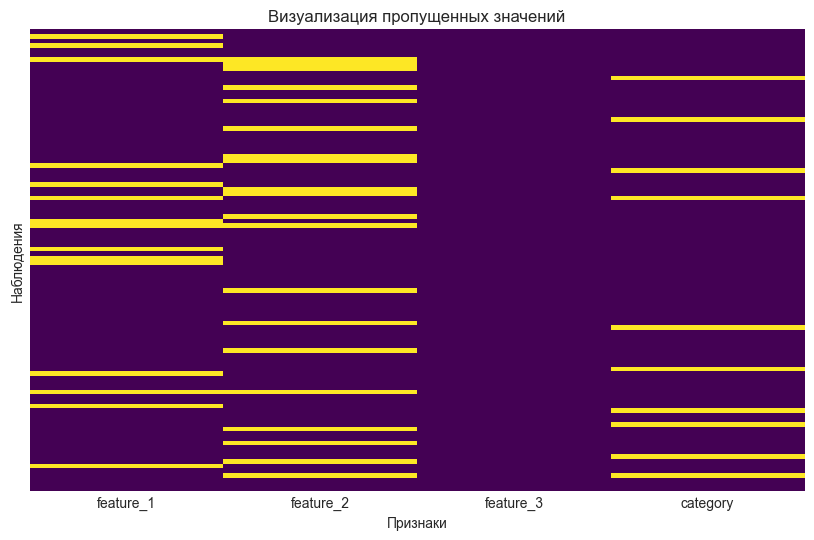

In [11]:
# Визуализация пропусков
import missingno as msno

# Если библиотека не установлена, можно использовать альтернативный метод
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Визуализация пропущенных значений')
plt.xlabel('Признаки')
plt.ylabel('Наблюдения')
plt.show()

In [6]:
# Метод 1: Удаление строк с пропусками
df_dropped = df.dropna()
print(f"После удаления строк: {df_dropped.shape[0]} строк (было {df.shape[0]})")

# Метод 2: Заполнение средним/медианой/модой
df_filled_mean = df.copy()
imputer_mean = SimpleImputer(strategy='mean')
df_filled_mean[['feature_1', 'feature_2', 'feature_3']] = imputer_mean.fit_transform(
    df_filled_mean[['feature_1', 'feature_2', 'feature_3']])

imputer_mode = SimpleImputer(strategy='most_frequent')
df_filled_mean[['category']] = imputer_mode.fit_transform(df_filled_mean[['category']])

print(f"\nПосле заполнения средним/модой: {df_filled_mean.isnull().sum().sum()} пропусков")

# Метод 3: KNN Imputer
df_knn = df.copy()
# Преобразуем категориальную переменную для KNN
df_knn['category_encoded'] = LabelEncoder().fit_transform(df_knn['category'].fillna('Missing'))
df_knn_temp = df_knn[['feature_1', 'feature_2', 'feature_3', 'category_encoded']]

knn_imputer = KNNImputer(n_neighbors=5)
df_knn_filled = pd.DataFrame(
    knn_imputer.fit_transform(df_knn_temp),
    columns=df_knn_temp.columns
)

print(f"После KNN Imputer: {df_knn_filled.isnull().sum().sum()} пропусков")

# Метод 4: Индикатор пропусков
df_indicator = df.copy()
df_indicator['feature_1_missing'] = df_indicator['feature_1'].isnull().astype(int)
df_indicator['feature_2_missing'] = df_indicator['feature_2'].isnull().astype(int)
df_indicator = df_indicator.fillna(df_indicator.mean(numeric_only=True))

print(f"\nС индикаторами пропусков: {df_indicator.shape[1]} признаков (было {df.shape[1]})")
print(df_indicator.head())

После удаления строк: 60 строк (было 100)

После заполнения средним/модой: 0 пропусков
После KNN Imputer: 0 пропусков

С индикаторами пропусков: 6 признаков (было 4)
   feature_1  feature_2  feature_3 category  feature_1_missing  \
0   0.496714  -1.415371   0.357787        A                  0   
1  -0.109635  -0.420645   0.560785        B                  1   
2   0.647689  -0.342715   1.083051        A                  0   
3  -0.109635  -0.802277   1.053802        A                  1   
4  -0.234153  -0.161286  -1.377669        C                  0   

   feature_2_missing  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  


## 2. Обработка выбросов (Outliers)

### Методы обнаружения:
1. **IQR (Interquartile Range)**: значения вне [Q1 - 1.5×IQR, Q3 + 1.5×IQR]
2. **Z-score**: |z| > 3 (более 3 стандартных отклонений)
3. **Isolation Forest**: алгоритм для обнаружения аномалий
4. **DBSCAN**: кластеризация с выделением шума

### Методы обработки:
1. Удаление выбросов
2. Ограничение (capping/winsorization)
3. Трансформация (log, sqrt)
4. Отдельная обработка как специальная категория

In [ ]:
# Создание данных с выбросами
np.random.seed(42)
normal_data = np.random.randn(200)
outliers = np.random.uniform(5, 10, 20)
data_with_outliers = np.concatenate([normal_data, outliers])
df_outliers = pd.DataFrame({'value': data_with_outliers})

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Гистограмма
axes[0].hist(df_outliers['value'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Гистограмма данных с выбросами')
axes[0].set_xlabel('Значение')
axes[0].set_ylabel('Частота')

# Box plot
axes[1].boxplot(df_outliers['value'])
axes[1].set_title('Box Plot')
axes[1].set_ylabel('Значение')

# Q-Q plot
stats.probplot(df_outliers['value'], dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot')

plt.tight_layout()
plt.show()

print(f"Статистика данных:")
print(df_outliers['value'].describe())

In [ ]:
# Метод 1: IQR метод
Q1 = df_outliers['value'].quantile(0.25)
Q3 = df_outliers['value'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = df_outliers[(df_outliers['value'] < lower_bound) | (df_outliers['value'] > upper_bound)]
print(f"IQR метод: обнаружено {len(outliers_iqr)} выбросов")
print(f"Границы: [{lower_bound:.2f}, {upper_bound:.2f}]")

# Удаление выбросов
df_no_outliers_iqr = df_outliers[(df_outliers['value'] >= lower_bound) & (df_outliers['value'] <= upper_bound)]

# Ограничение выбросов (capping)
df_capped = df_outliers.copy()
df_capped['value'] = df_capped['value'].clip(lower=lower_bound, upper=upper_bound)

print(f"После удаления: {len(df_no_outliers_iqr)} наблюдений")
print(f"После ограничения: {len(df_capped)} наблюдений")

In [ ]:
# Метод 2: Z-score
z_scores = np.abs(stats.zscore(df_outliers['value']))
threshold = 3
outliers_zscore = df_outliers[z_scores > threshold]
print(f"Z-score метод (|z| > {threshold}): обнаружено {len(outliers_zscore)} выбросов")

df_no_outliers_zscore = df_outliers[z_scores <= threshold]
print(f"После удаления: {len(df_no_outliers_zscore)} наблюдений")

In [ ]:
# Метод 3: Isolation Forest
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.1, random_state=42)
outliers_if = iso_forest.fit_predict(df_outliers[['value']])
df_outliers['outlier_if'] = outliers_if

print(f"Isolation Forest: обнаружено {sum(outliers_if == -1)} выбросов")

df_no_outliers_if = df_outliers[df_outliers['outlier_if'] == 1]
print(f"После удаления: {len(df_no_outliers_if)} наблюдений")

In [ ]:
# Сравнение методов визуально
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Исходные данные
axes[0, 0].hist(df_outliers['value'], bins=30, edgecolor='black', alpha=0.7, color='red')
axes[0, 0].axvline(lower_bound, color='green', linestyle='--', label='IQR bounds')
axes[0, 0].axvline(upper_bound, color='green', linestyle='--')
axes[0, 0].set_title(f'Исходные данные (n={len(df_outliers)})')
axes[0, 0].legend()

# После IQR
axes[0, 1].hist(df_no_outliers_iqr['value'], bins=30, edgecolor='black', alpha=0.7, color='blue')
axes[0, 1].set_title(f'После IQR (n={len(df_no_outliers_iqr)})')

# После Z-score
axes[1, 0].hist(df_no_outliers_zscore['value'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_title(f'После Z-score (n={len(df_no_outliers_zscore)})')

# После Isolation Forest
axes[1, 1].hist(df_no_outliers_if['value'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].set_title(f'После Isolation Forest (n={len(df_no_outliers_if)})')

for ax in axes.flat:
    ax.set_xlabel('Значение')
    ax.set_ylabel('Частота')

plt.tight_layout()
plt.show()

## 3. Удаление шумов и сглаживание

### Методы:
1. **Скользящее среднее** (Moving Average)
2. **Медианный фильтр**
3. **Гауссовское сглаживание**
4. **Фильтр Савицкого-Голея**

In [ ]:
from scipy.ndimage import gaussian_filter1d, median_filter
from scipy.signal import savgol_filter

# Создание зашумленных данных
np.random.seed(42)
x = np.linspace(0, 10, 200)
y_true = np.sin(x) + 0.5 * np.sin(3 * x)
noise = np.random.normal(0, 0.3, len(x))
y_noisy = y_true + noise

# Применение различных методов
# Скользящее среднее
window_size = 10
y_moving_avg = pd.Series(y_noisy).rolling(window=window_size, center=True).mean()

# Медианный фильтр
y_median = median_filter(y_noisy, size=10)

# Гауссовское сглаживание
y_gaussian = gaussian_filter1d(y_noisy, sigma=2)

# Фильтр Савицкого-Голея
y_savgol = savgol_filter(y_noisy, window_length=21, polyorder=3)

# Визуализация
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

axes[0, 0].plot(x, y_true, 'g-', linewidth=2, label='Истинный сигнал')
axes[0, 0].plot(x, y_noisy, 'r.', alpha=0.3, label='Зашумленный сигнал')
axes[0, 0].set_title('Исходные данные')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(x, y_true, 'g-', linewidth=2, label='Истинный')
axes[0, 1].plot(x, y_moving_avg, 'b-', linewidth=2, label='Скользящее среднее')
axes[0, 1].set_title('Скользящее среднее')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].plot(x, y_true, 'g-', linewidth=2, label='Истинный')
axes[0, 2].plot(x, y_median, 'm-', linewidth=2, label='Медианный фильтр')
axes[0, 2].set_title('Медианный фильтр')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].plot(x, y_true, 'g-', linewidth=2, label='Истинный')
axes[1, 0].plot(x, y_gaussian, 'c-', linewidth=2, label='Гауссовское')
axes[1, 0].set_title('Гауссовское сглаживание')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(x, y_true, 'g-', linewidth=2, label='Истинный')
axes[1, 1].plot(x, y_savgol, 'orange', linewidth=2, label='Савицкий-Голей')
axes[1, 1].set_title('Фильтр Савицкого-Голея')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Сравнение ошибок
methods = ['Moving Avg', 'Median', 'Gaussian', 'Savgol']
y_filtered = [y_moving_avg.fillna(method='bfill').fillna(method='ffill'), 
              y_median, y_gaussian, y_savgol]
mse_errors = [np.mean((y_true - y_f)**2) for y_f in y_filtered]

axes[1, 2].bar(methods, mse_errors, color=['blue', 'magenta', 'cyan', 'orange'])
axes[1, 2].set_title('Сравнение MSE ошибок')
axes[1, 2].set_ylabel('MSE')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("MSE для каждого метода:")
for method, mse in zip(methods, mse_errors):
    print(f"{method}: {mse:.4f}")

## 4. Масштабирование признаков

### Зачем нужно масштабирование?
- Алгоритмы на основе расстояний (KNN, SVM, K-means) чувствительны к масштабу
- Градиентный спуск сходится быстрее
- Регуляризация работает корректно

### Методы:
1. **StandardScaler**: $(x - \mu) / \sigma$ (mean=0, std=1)
2. **MinMaxScaler**: $(x - x_{min}) / (x_{max} - x_{min})$ (диапазон [0, 1])
3. **RobustScaler**: использует медиану и IQR (устойчив к выбросам)
4. **MaxAbsScaler**: $x / |x_{max}|$ (диапазон [-1, 1])
5. **Normalizer**: нормализация по строкам (||x|| = 1)

In [ ]:
from sklearn.preprocessing import MaxAbsScaler, Normalizer

# Создание данных с разными масштабами
np.random.seed(42)
df_scale = pd.DataFrame({
    'feature_small': np.random.uniform(0, 1, 100),
    'feature_medium': np.random.uniform(0, 100, 100),
    'feature_large': np.random.uniform(0, 10000, 100)
})

print("Исходные данные:")
print(df_scale.describe())

# Применение разных методов масштабирования
scalers = {
    'Standard': StandardScaler(),
    'MinMax': MinMaxScaler(),
    'Robust': RobustScaler(),
    'MaxAbs': MaxAbsScaler()
}

scaled_data = {}
for name, scaler in scalers.items():
    scaled_data[name] = pd.DataFrame(
        scaler.fit_transform(df_scale),
        columns=df_scale.columns
    )

# Визуализация
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

# Исходные данные
df_scale.boxplot(ax=axes[0])
axes[0].set_title('Исходные данные')
axes[0].set_ylabel('Значение')
axes[0].tick_params(axis='x', rotation=45)

# Масштабированные данные
for idx, (name, data) in enumerate(scaled_data.items(), 1):
    data.boxplot(ax=axes[idx])
    axes[idx].set_title(f'{name} Scaler')
    axes[idx].set_ylabel('Значение')
    axes[idx].tick_params(axis='x', rotation=45)
    
    print(f"\n{name} Scaler:")
    print(data.describe())

# Сравнение распределений для одного признака
axes[5].hist(df_scale['feature_medium'], bins=20, alpha=0.5, label='Original', edgecolor='black')
axes[5].hist(scaled_data['Standard']['feature_medium'], bins=20, alpha=0.5, label='Standard', edgecolor='black')
axes[5].hist(scaled_data['MinMax']['feature_medium'], bins=20, alpha=0.5, label='MinMax', edgecolor='black')
axes[5].set_title('Сравнение распределений (feature_medium)')
axes[5].legend()

plt.tight_layout()
plt.show()

## 5. Кодирование категориальных переменных

### Методы:
1. **Label Encoding**: присвоение числовых меток (0, 1, 2, ...)
2. **One-Hot Encoding**: бинарные столбцы для каждой категории
3. **Target Encoding**: замена на среднее значение целевой переменной
4. **Frequency Encoding**: замена на частоту появления
5. **Binary Encoding**: бинарное представление меток
6. **Ordinal Encoding**: для упорядоченных категорий

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

# Создание данных с категориальными переменными
np.random.seed(42)
df_cat = pd.DataFrame({
    'color': np.random.choice(['red', 'blue', 'green', 'yellow'], 100),
    'size': np.random.choice(['S', 'M', 'L', 'XL'], 100),
    'quality': np.random.choice(['low', 'medium', 'high'], 100),
    'target': np.random.randint(0, 2, 100)
})

print("Исходные данные:")
print(df_cat.head(10))
print("\nКоличество уникальных значений:")
print(df_cat.nunique())

In [ ]:
# Метод 1: Label Encoding
df_label = df_cat.copy()
le = LabelEncoder()
df_label['color_encoded'] = le.fit_transform(df_label['color'])

print("Label Encoding:")
print(df_label[['color', 'color_encoded']].head())
print("\nМаппинг:", dict(zip(le.classes_, le.transform(le.classes_))))

In [ ]:
# Метод 2: One-Hot Encoding
df_onehot = pd.get_dummies(df_cat, columns=['color'], prefix='color')

print("One-Hot Encoding:")
print(df_onehot.head())
print(f"\nКоличество признаков: {df_onehot.shape[1]} (было {df_cat.shape[1]})")

In [ ]:
# Метод 3: Target Encoding
df_target = df_cat.copy()
target_means = df_target.groupby('color')['target'].mean()
df_target['color_target_encoded'] = df_target['color'].map(target_means)

print("Target Encoding:")
print(df_target[['color', 'color_target_encoded', 'target']].head(10))
print("\nМаппинг (среднее значение target):")
print(target_means)

In [ ]:
# Метод 4: Frequency Encoding
df_freq = df_cat.copy()
freq = df_freq['color'].value_counts(normalize=True)
df_freq['color_freq_encoded'] = df_freq['color'].map(freq)

print("Frequency Encoding:")
print(df_freq[['color', 'color_freq_encoded']].head(10))
print("\nЧастоты:")
print(freq)

In [ ]:
# Метод 5: Ordinal Encoding (для упорядоченных категорий)
df_ordinal = df_cat.copy()

# Определяем порядок
size_order = ['S', 'M', 'L', 'XL']
quality_order = ['low', 'medium', 'high']

# Создаем маппинг
size_mapping = {size: idx for idx, size in enumerate(size_order)}
quality_mapping = {quality: idx for idx, quality in enumerate(quality_order)}

df_ordinal['size_encoded'] = df_ordinal['size'].map(size_mapping)
df_ordinal['quality_encoded'] = df_ordinal['quality'].map(quality_mapping)

print("Ordinal Encoding:")
print(df_ordinal[['size', 'size_encoded', 'quality', 'quality_encoded']].head())
print("\nSize mapping:", size_mapping)
print("Quality mapping:", quality_mapping)

## 6. Feature Engineering - создание новых признаков

### Типы создаваемых признаков:
1. **Полиномиальные признаки**: $x_1^2, x_1 \cdot x_2$, etc.
2. **Математические трансформации**: log, sqrt, exp
3. **Агрегации**: sum, mean, max, min
4. **Временные признаки**: год, месяц, день недели
5. **Статистические признаки**: rolling mean, std
6. **Доменные признаки**: специфичные для задачи

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Создание исходных данных
np.random.seed(42)
df_fe = pd.DataFrame({
    'x1': np.random.randn(100),
    'x2': np.random.randn(100),
    'x3': np.random.uniform(1, 10, 100)
})

print("Исходные признаки:")
print(df_fe.head())
print(f"Количество признаков: {df_fe.shape[1]}")

In [ ]:
# 1. Полиномиальные признаки
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df_fe)
poly_features = poly.get_feature_names_out(df_fe.columns)

df_poly = pd.DataFrame(X_poly, columns=poly_features)
print("Полиномиальные признаки (degree=2):")
print(df_poly.head())
print(f"\nКоличество признаков: {df_poly.shape[1]} (было {df_fe.shape[1]})")
print("Новые признаки:", list(poly_features))

In [ ]:
# 2. Математические трансформации
df_math = df_fe.copy()

# Логарифм (только для положительных значений)
df_math['x3_log'] = np.log(df_math['x3'])

# Квадратный корень (для положительных значений)
df_math['x3_sqrt'] = np.sqrt(df_math['x3'])

# Квадрат
df_math['x1_squared'] = df_math['x1'] ** 2

# Экспонента
df_math['x1_exp'] = np.exp(df_math['x1'])

# Взаимодействия
df_math['x1_x2_interaction'] = df_math['x1'] * df_math['x2']
df_math['x1_x2_ratio'] = df_math['x1'] / (df_math['x2'] + 1e-5)  # избегаем деления на 0

print("Математические трансформации:")
print(df_math.head())
print(f"\nКоличество признаков: {df_math.shape[1]}")

In [ ]:
# 3. Агрегированные признаки
df_agg = df_fe.copy()

# Сумма всех признаков
df_agg['sum_all'] = df_agg.sum(axis=1)

# Среднее значение
df_agg['mean_all'] = df_agg.mean(axis=1)

# Максимум и минимум
df_agg['max_all'] = df_agg.max(axis=1)
df_agg['min_all'] = df_agg.min(axis=1)

# Разница между max и min
df_agg['range_all'] = df_agg['max_all'] - df_agg['min_all']

# Стандартное отклонение
df_agg['std_all'] = df_agg[['x1', 'x2', 'x3']].std(axis=1)

print("Агрегированные признаки:")
print(df_agg.head())

In [ ]:
# 4. Временные признаки
dates = pd.date_range('2024-01-01', periods=100, freq='D')
df_time = pd.DataFrame({'date': dates})

# Извлечение компонентов даты
df_time['year'] = df_time['date'].dt.year
df_time['month'] = df_time['date'].dt.month
df_time['day'] = df_time['date'].dt.day
df_time['day_of_week'] = df_time['date'].dt.dayofweek
df_time['week_of_year'] = df_time['date'].dt.isocalendar().week
df_time['is_weekend'] = df_time['day_of_week'].isin([5, 6]).astype(int)
df_time['quarter'] = df_time['date'].dt.quarter

# Циклические признаки (для периодических величин)
df_time['month_sin'] = np.sin(2 * np.pi * df_time['month'] / 12)
df_time['month_cos'] = np.cos(2 * np.pi * df_time['month'] / 12)
df_time['day_sin'] = np.sin(2 * np.pi * df_time['day_of_week'] / 7)
df_time['day_cos'] = np.cos(2 * np.pi * df_time['day_of_week'] / 7)

print("Временные признаки:")
print(df_time.head(10))

# Визуализация циклических признаков
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].scatter(df_time['month_sin'], df_time['month_cos'], c=df_time['month'], cmap='hsv')
ax[0].set_xlabel('month_sin')
ax[0].set_ylabel('month_cos')
ax[0].set_title('Циклическое представление месяцев')
ax[0].grid(True, alpha=0.3)

ax[1].scatter(df_time['day_sin'], df_time['day_cos'], c=df_time['day_of_week'], cmap='viridis')
ax[1].set_xlabel('day_sin')
ax[1].set_ylabel('day_cos')
ax[1].set_title('Циклическое представление дней недели')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Feature Selection - отбор признаков

### Зачем нужен отбор признаков?
- Уменьшение переобучения
- Улучшение производительности модели
- Снижение вычислительной сложности
- Улучшение интерпретируемости

### Методы отбора:
1. **Filter Methods**: статистические тесты (корреляция, chi-square, mutual information)
2. **Wrapper Methods**: RFE, Forward/Backward selection
3. **Embedded Methods**: Lasso, Random Forest feature importance
4. **Variance Threshold**: удаление признаков с низкой дисперсией

In [ ]:
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, mutual_info_classif
from sklearn.linear_model import LogisticRegression

# Создание датасета для демонстрации
X, y = make_classification(n_samples=1000, n_features=30, n_informative=15, 
                           n_redundant=10, n_repeated=5, random_state=42)
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
df_fs = pd.DataFrame(X, columns=feature_names)
df_fs['target'] = y

print(f"Исходный датасет: {X.shape[0]} образцов, {X.shape[1]} признаков")
print(f"Распределение классов: {np.bincount(y)}")

In [ ]:
# 1. Variance Threshold - удаление признаков с низкой дисперсией
selector_var = VarianceThreshold(threshold=0.1)
X_var = selector_var.fit_transform(X)

print(f"Variance Threshold:")
print(f"Признаков после фильтрации: {X_var.shape[1]} (удалено {X.shape[1] - X_var.shape[1]})")

# Визуализация дисперсии признаков
variances = X.var(axis=0)
plt.figure(figsize=(12, 4))
plt.bar(range(len(variances)), variances)
plt.axhline(y=0.1, color='r', linestyle='--', label='Threshold')
plt.xlabel('Индекс признака')
plt.ylabel('Дисперсия')
plt.title('Дисперсия признаков')
plt.legend()
plt.show()

In [ ]:
# 2. Корреляционный анализ
# Корреляция между признаками
correlation_matrix = df_fs.drop('target', axis=1).corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций признаков')
plt.tight_layout()
plt.show()

# Поиск высококоррелированных пар
threshold_corr = 0.8
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold_corr:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

print(f"\nВысококоррелированные пары (|r| > {threshold_corr}):")
for feat1, feat2, corr in high_corr_pairs[:10]:
    print(f"{feat1} - {feat2}: {corr:.3f}")

In [ ]:
# 3. Univariate Feature Selection - SelectKBest
# F-test (ANOVA)
k_best = 15
selector_ftest = SelectKBest(score_func=f_classif, k=k_best)
X_ftest = selector_ftest.fit_transform(X, y)

# Получение оценок
ftest_scores = selector_ftest.scores_
ftest_features = selector_ftest.get_support(indices=True)

print(f"SelectKBest (F-test):")
print(f"Выбрано {k_best} лучших признаков")
print(f"Индексы: {ftest_features}")

# Визуализация оценок
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(range(len(ftest_scores)), ftest_scores)
plt.xlabel('Индекс признака')
plt.ylabel('F-score')
plt.title('F-test scores для признаков')

# Mutual Information
mi_scores = mutual_info_classif(X, y, random_state=42)

plt.subplot(1, 2, 2)
plt.bar(range(len(mi_scores)), mi_scores)
plt.xlabel('Индекс признака')
plt.ylabel('MI score')
plt.title('Mutual Information scores')

plt.tight_layout()
plt.show()

In [ ]:
# 4. Recursive Feature Elimination (RFE)
estimator = LogisticRegression(max_iter=1000, random_state=42)
selector_rfe = RFE(estimator, n_features_to_select=15, step=1)
X_rfe = selector_rfe.fit_transform(X, y)

print(f"RFE (Recursive Feature Elimination):")
print(f"Выбрано признаков: {X_rfe.shape[1]}")
print(f"Ранги признаков:")
for idx, (rank, selected) in enumerate(zip(selector_rfe.ranking_, selector_rfe.support_)):
    if selected:
        print(f"Feature {idx}: rank {rank} (selected)")

In [ ]:
# 5. Feature Importance из Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Получение важности признаков
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature Importance (Random Forest):")
print("\nТоп-15 самых важных признаков:")
for i in range(15):
    print(f"{i+1}. feature_{indices[i]}: {importances[indices[i]]:.4f}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xlabel('Индекс признака (отсортировано)')
plt.ylabel('Важность')
plt.title('Feature Importance из Random Forest')
plt.show()

# Отбор признаков по порогу важности
selector_rf = SelectFromModel(rf, threshold='median', prefit=True)
X_rf = selector_rf.transform(X)
print(f"\nПризнаков после SelectFromModel: {X_rf.shape[1]}")

In [ ]:
# 6. L1-регуляризация (Lasso) для отбора признаков
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X, y)

# Признаки с ненулевыми коэффициентами
lasso_coef = lasso.coef_
selected_features_lasso = np.where(lasso_coef != 0)[0]

print(f"L1-регуляризация (Lasso):")
print(f"Выбрано признаков: {len(selected_features_lasso)}")
print(f"Индексы: {selected_features_lasso}")

# Визуализация коэффициентов
plt.figure(figsize=(12, 5))
plt.bar(range(len(lasso_coef)), np.abs(lasso_coef))
plt.xlabel('Индекс признака')
plt.ylabel('|Коэффициент|')
plt.title('Абсолютные значения коэффициентов Lasso')
plt.show()

In [ ]:
# Сравнение всех методов
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

methods = {
    'Все признаки': X,
    'Variance Threshold': X_var,
    'SelectKBest (F-test)': X_ftest,
    'RFE': X_rfe,
    'Random Forest': X_rf,
}

results = []
for name, X_selected in methods.items():
    # Кросс-валидация
    clf = LogisticRegression(max_iter=1000, random_state=42)
    scores = cross_val_score(clf, X_selected, y, cv=5, scoring='accuracy')
    
    results.append({
        'Method': name,
        'Features': X_selected.shape[1],
        'Mean Accuracy': scores.mean(),
        'Std': scores.std()
    })

results_df = pd.DataFrame(results)
print("\nСравнение методов отбора признаков:")
print(results_df.to_string(index=False))

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График точности
axes[0].barh(results_df['Method'], results_df['Mean Accuracy'], 
             xerr=results_df['Std'], capsize=5, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Mean Accuracy (CV=5)')
axes[0].set_title('Сравнение точности моделей')
axes[0].grid(True, alpha=0.3)

# График количества признаков vs точность
axes[1].scatter(results_df['Features'], results_df['Mean Accuracy'], s=200, alpha=0.6)
for idx, row in results_df.iterrows():
    axes[1].annotate(row['Method'], 
                     (row['Features'], row['Mean Accuracy']),
                     fontsize=8, ha='right')
axes[1].set_xlabel('Количество признаков')
axes[1].set_ylabel('Mean Accuracy')
axes[1].set_title('Количество признаков vs Точность')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Резюме

### Основные этапы предобработки:

1. **Работа с пропусками**:
   - Анализ паттернов пропусков (MCAR, MAR, MNAR)
   - Выбор стратегии: удаление, заполнение или создание индикаторов
   - KNN Imputer для сложных зависимостей

2. **Обработка выбросов**:
   - IQR для симметричных распределений
   - Z-score для нормальных распределений
   - Isolation Forest для многомерных данных
   - Выбор между удалением и ограничением

3. **Удаление шумов**:
   - Скользящее среднее для временных рядов
   - Медианный фильтр для сохранения резких переходов
   - Гауссовское сглаживание для общего случая
   - Савицкий-Голей для научных данных

4. **Масштабирование**:
   - StandardScaler для нормального распределения
   - MinMaxScaler для ограниченного диапазона
   - RobustScaler при наличии выбросов

5. **Кодирование категорий**:
   - One-Hot для номинальных признаков
   - Ordinal для упорядоченных категорий
   - Target Encoding с осторожностью (risk of overfitting)

6. **Feature Engineering**:
   - Полиномиальные признаки для нелинейностей
   - Математические трансформации для нормализации
   - Агрегации для создания обобщенных признаков
   - Циклические признаки для периодических данных

7. **Feature Selection**:
   - Filter methods для быстрой первичной фильтрации
   - Wrapper methods для оптимального набора
   - Embedded methods для интеграции с обучением
   - Баланс между количеством признаков и качеством модели

### Рекомендации:
- Всегда начинайте с EDA (разведочного анализа)
- Документируйте все преобразования
- Используйте pipeline для воспроизводимости
- Применяйте одинаковые преобразования к train/test
- Валидируйте результаты на тестовой выборке